In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
img = cv2.imread('shapes.png', cv2.IMREAD_GRAYSCALE)
_, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)


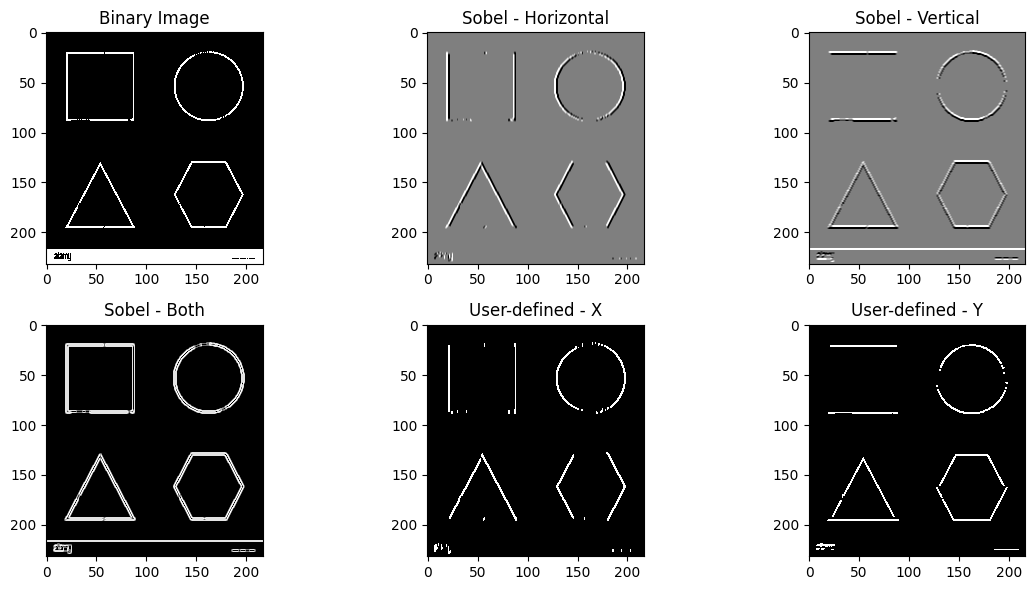

In [15]:
# Apply Sobel edge detection (Built-in)
sobelx = cv2.Sobel(thresh, cv2.CV_64F, 1, 0)
sobely = cv2.Sobel(thresh, cv2.CV_64F, 0, 1)
sobel_both = cv2.magnitude(sobelx, sobely)

# User-defined horizontal and vertical edge detection kernels
kernel_x = np.array([[1, 0, -1],
                     [1, 0, -1],
                     [1, 0, -1]])
kernel_y = np.array([[1, 1, 1],
                     [0, 0, 0],
                     [-1, -1, -1]])

edge_x = cv2.filter2D(thresh, -1, kernel_x)
edge_y = cv2.filter2D(thresh, -1, kernel_y)
edge_combined = cv2.addWeighted(edge_x, 0.5, edge_y, 0.5, 0)

# Show results
plt.figure(figsize=(12, 6))
plt.subplot(231), plt.imshow(thresh, cmap='gray'), plt.title("Binary Image")
plt.subplot(232), plt.imshow(sobelx, cmap='gray'), plt.title("Sobel - Horizontal")
plt.subplot(233), plt.imshow(sobely, cmap='gray'), plt.title("Sobel - Vertical")
plt.subplot(234), plt.imshow(sobel_both, cmap='gray'), plt.title("Sobel - Both")
plt.subplot(235), plt.imshow(edge_x, cmap='gray'), plt.title("User-defined - X")
plt.subplot(236), plt.imshow(edge_y, cmap='gray'), plt.title("User-defined - Y")
plt.tight_layout()
plt.show()


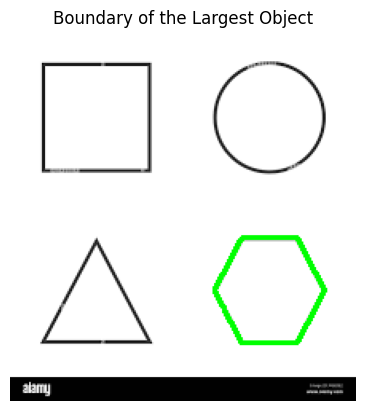

In [16]:
# Find contours and get the largest one
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)

# Draw the largest boundary
boundary_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(boundary_img, [largest_contour], -1, (0, 255, 0), 2)

# Display result
plt.imshow(boundary_img)
plt.title("Boundary of the Largest Object")
plt.axis('off')
plt.show()


In [17]:
def get_4dir_chain_code(contour):
    code = []
    direction_map = {(1, 0): 0, (0, 1): 1, (-1, 0): 2, (0, -1): 3}
    for i in range(1, len(contour)):
        dx = contour[i][0][0] - contour[i-1][0][0]
        dy = contour[i][0][1] - contour[i-1][0][1]
        if (dx, dy) in direction_map:
            code.append(direction_map[(dx, dy)])
    return code

chain_code = get_4dir_chain_code(largest_contour)
print("Chain Code (first 30 values):", chain_code[:30])


Chain Code (first 30 values): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3]


In [18]:
x, y, w, h = cv2.boundingRect(largest_contour)
aspect_ratio = w / float(h)
area = cv2.contourArea(largest_contour)
rect_area = w * h
extent = area / rect_area
hull = cv2.convexHull(largest_contour)
hull_area = cv2.contourArea(hull)
solidity = area / hull_area

shape_descriptor = {
    "Aspect Ratio": round(aspect_ratio, 2),
    "Extent": round(extent, 2),
    "Solidity": round(solidity, 2)
}

print("Shape Descriptor:")
for k, v in shape_descriptor.items():
    print(f"{k}: {v}")


Shape Descriptor:
Aspect Ratio: 1.04
Extent: 0.73
Solidity: 0.99


In [19]:
def classify_shape(contour):
    approx = cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)
    vertices = len(approx)
    if vertices == 3:
        return "Triangle"
    elif vertices == 4:
        x, y, w, h = cv2.boundingRect(approx)
        ar = w / float(h)
        return "Square" if 0.95 <= ar <= 1.05 else "Rectangle"
    elif vertices > 4:
        return "Circle"
    return "Unknown"

shape_type = classify_shape(largest_contour)
print("Shape Classification:", shape_type)


Shape Classification: Circle
